In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env1 = gym.make('CartPole-v1')
env1.seed(0)

# state_shape = env.observation_space.shape[0]
# no_of_actions = env.action_space.n

# print(state_shape)
# print(no_of_actions)
# print(env.action_space.sample())
# print("----")

# '''
# # Understanding State, Action, Reward Dynamics

# The agent decides an action to take depending on the state.

# The Environment keeps a variable specifically for the current state.
# - Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
# - It returns the new current state and reward for the agent to take the next action

# '''

# state = env.reset()
# ''' This returns the initial state (when environment is reset) '''

# print(state)
# print("----")

# action = env.action_space.sample()
# ''' We take a random action now '''

# print(action)
# print("----")

# next_state, reward, done, info = env.step(action)
# ''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

# print(next_state)
# print(reward)
# print(done)
# print(info)
# print("----")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

[0]

In [4]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4
TAU = 0.05              # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)



class DuelingDQN(nn.Module):

    def __init__(self, input_dim, output_dim, update_type, seed, fc1_units=64, fc2_units=64, fc3_units = 32):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.update_type = update_type #The mean of the max operator type is choosen here based on the update rule choosen
        if self.update_type == 1:
          self.operator = torch.mean
        elif self.update_type ==2:
          self.operator = torch.max
        self.seed = torch.manual_seed(seed)
        self.feauture_layer = nn.Sequential(
            nn.Linear(self.input_dim, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU()
        ) #Shared features between value and advantages networks

        self.value_stream = nn.Sequential(
            nn.Linear(fc2_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(fc2_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, self.output_dim)
        )

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - self.operator(advantages)) #need to add another update eqn.

        return qvals


In [5]:
# def compute_loss(self, batch):
#         states, actions, rewards, next_states, dones = batch #need to see what kinda batch i need to put
#         states = torch.FloatTensor(states).to(self.device)
#         actions = torch.LongTensor(actions).to(self.device)
#         rewards = torch.FloatTensor(rewards).to(self.device)
#         next_states = torch.FloatTensor(next_states).to(self.device)
#         dones = torch.FloatTensor(dones).to(self.device)

#         curr_Q = self.model.forward(states).gather(1, actions.unsqueeze(1))
#         curr_Q = curr_Q.squeeze(1)
#         next_Q = self.model.forward(next_states)
#         max_next_Q = torch.max(next_Q, 1)[0]
#         expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q #already there in tutorialAgent code?

#         loss = self.MSE_loss(curr_Q, expected_Q)

#         return loss

# def update(self, batch_size): #already there in tutagent code?
#     batch = self.replay_buffer.sample(batch_size)
#     loss = self.compute_loss(batch)

#     self.optimizer.zero_grad()
#     loss.backward()
#     self.optimizer.step()

In [6]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
class TutorialAgent():

    def __init__(self, state_size, action_size, update_type, seed, tau = 0.01):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.update_type = update_type
        self.tau = tau

        ''' Q-Network '''
        self.qnetwork_local = DuelingDQN(state_size, action_size, self.update_type, seed).to(device)
        self.qnetwork_target = DuelingDQN(state_size, action_size,self.update_type,  seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
            for target_param, param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
              target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

In [9]:
def dqn(env, agent, n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.08, eps_decay=0.95):

    scores = []
    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    scores_window_printing = deque(maxlen=10)
    ''' For printing in the graph '''

    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_window_printing.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        scores.append(np.mean(scores_window_printing))

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=195.0:
        #    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return [np.array(scores),i_episode]


In [12]:
''' Defining DQN Algorithm '''

state_shape = env1.observation_space.shape[0]
action_shape = env1.action_space.n



''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

scores_5runs_type1 = []
for i in range(5):

  print("Run: ", i)
  seed = random.randint(0, 1e5)
  env = gym.make('CartPole-v1')
  env.seed(seed)
  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape, update_type = 1,seed = seed, tau = TAU)
  scores, ep = dqn(env, agent)
  scores_5runs_type1.append(scores)

scores_5runs_type2 = []
for i in range(5):
  print("Run: ", i)
  seed = random.randint(0, 1e5)
  env = gym.make('CartPole-v1')
  env.reset(seed)
  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape, update_type = 2,seed = seed, tau = TAU)
  scores, ep = dqn(env, agent)
  scores_5runs_type2.append(scores)
  env.close()

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

/usr/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Run:  0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 49.72
Episode 200	Average Score: 337.47
Episode 300	Average Score: 126.67
Episode 400	Average Score: 158.36
Episode 500	Average Score: 329.11
Run:  1


/usr/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(s

Episode 100	Average Score: 20.32
Episode 200	Average Score: 179.99
Episode 300	Average Score: 240.90
Episode 400	Average Score: 57.08
Episode 500	Average Score: 9.66
Run:  2
Episode 100	Average Score: 83.26
Episode 200	Average Score: 150.66
Episode 300	Average Score: 146.71
Episode 400	Average Score: 148.73
Episode 500	Average Score: 434.47
Run:  3
Episode 100	Average Score: 13.68
Episode 200	Average Score: 172.93
Episode 300	Average Score: 246.24
Episode 400	Average Score: 214.27
Episode 500	Average Score: 150.75
Run:  4
Episode 100	Average Score: 40.60
Episode 200	Average Score: 176.96
Episode 300	Average Score: 162.11
Episode 400	Average Score: 203.29
Episode 500	Average Score: 258.61
Run:  0
Episode 100	Average Score: 12.00
Episode 200	Average Score: 207.08
Episode 300	Average Score: 242.55
Episode 400	Average Score: 327.14
Episode 500	Average Score: 49.84
Run:  1
Episode 100	Average Score: 11.74
Episode 200	Average Score: 93.01
Episode 300	Average Score: 162.76
Episode 400	Average

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


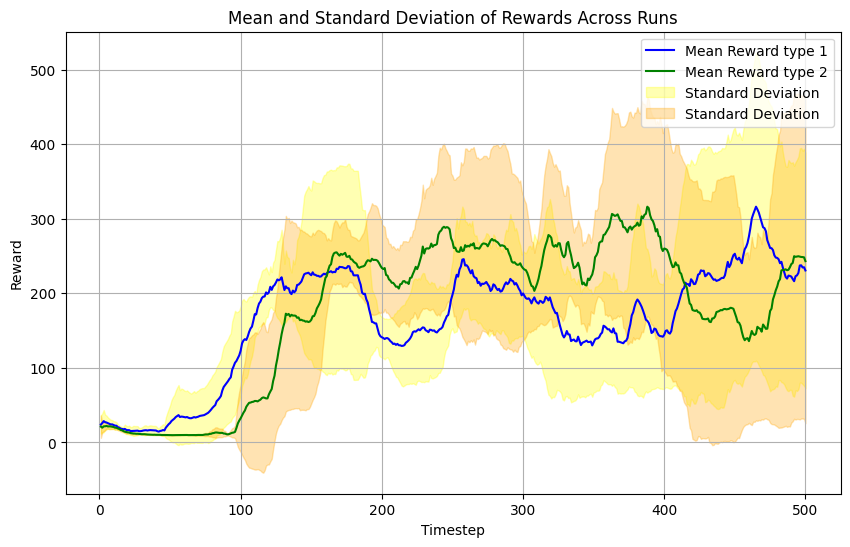

In [13]:
rewards1 = np.array(scores_5runs_type1)
mean_rewards1 = np.mean(rewards1, axis=0)
std_rewards1 = np.std(rewards1, axis=0)
timesteps1 = np.arange(1, rewards1.shape[1] + 1)

rewards2 = np.array(scores_5runs_type2)
mean_rewards2 = np.mean(rewards2, axis=0)
std_rewards2 = np.std(rewards2, axis=0)
timesteps2 = np.arange(1, rewards2.shape[1] + 1)

plt.figure(figsize=(10, 6))
plt.plot(timesteps1, mean_rewards1, label='Mean Reward type 1', color='blue')
plt.plot(timesteps2, mean_rewards2, label='Mean Reward type 2', color='green')
plt.fill_between(timesteps1, mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1,
                  alpha=0.3, color='yellow', label='Standard Deviation')
plt.fill_between(timesteps2, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2,
                  alpha=0.3, color='orange', label='Standard Deviation')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Mean and Standard Deviation of Rewards Across Runs')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
begin_time = datetime.datetime.now()

scores_5runs_type1_acrobat = []
for i in range(5):

  print("Run: ", i)
  seed = random.randint(0, 1e5)
  env = gym.make('Acrobot-v1')
  env.seed(seed)
  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape, update_type = 1,seed = seed, tau = TAU)
  scores, ep = dqn(env, agent)
  scores_5runs_type1_acrobat.append(scores)
  env.close()

scores_5runs_type2_acrobat = []
for i in range(5):
  print("Run: ", i)
  seed = random.randint(0, 1e5)
  env = gym.make('Acrobot-v1')
  env.seed(seed)
  state_shape = env.observation_space.shape[0]
  action_shape = env.action_space.n
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape, update_type = 2,seed = seed, tau = TAU)
  scores, ep = dqn(env, agent)
  scores_5runs_type2_acrobat.append(scores)
  env.close()

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API wh

Run:  0
Episode 100	Average Score: -213.91
Episode 200	Average Score: -113.64
Episode 300	Average Score: -96.30
Episode 400	Average Score: -90.96
Episode 500	Average Score: -86.45
Run:  1
Episode 100	Average Score: -213.28
Episode 200	Average Score: -102.65
Episode 300	Average Score: -92.99
Episode 400	Average Score: -91.98
Episode 500	Average Score: -87.64
Run:  2
Episode 100	Average Score: -362.42
Episode 200	Average Score: -138.76
Episode 300	Average Score: -118.20
Episode 400	Average Score: -94.65
Episode 500	Average Score: -93.93
Run:  3
Episode 100	Average Score: -179.83
Episode 200	Average Score: -107.07
Episode 300	Average Score: -100.63
Episode 400	Average Score: -90.60
Episode 500	Average Score: -93.68
Run:  4
Episode 100	Average Score: -186.85
Episode 200	Average Score: -107.25
Episode 300	Average Score: -92.81
Episode 400	Average Score: -89.98
Episode 500	Average Score: -90.14
Run:  0
Episode 100	Average Score: -212.73
Episode 200	Average Score: -96.75
Episode 300	Average S

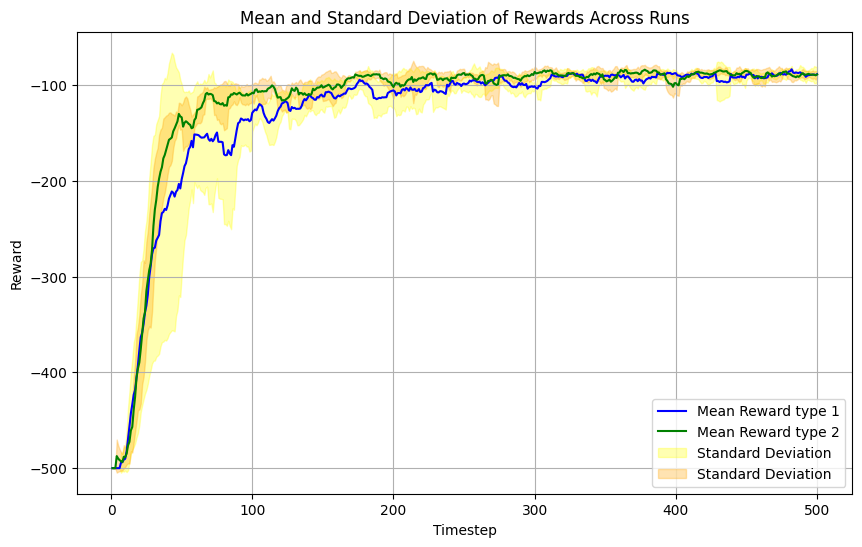

In [12]:
rewards1 = np.array(scores_5runs_type1_acrobat)
mean_rewards1 = np.mean(rewards1, axis=0)
std_rewards1 = np.std(rewards1, axis=0)
timesteps1 = np.arange(1, rewards1.shape[1] + 1)

rewards2 = np.array(scores_5runs_type2_acrobat)
mean_rewards2 = np.mean(rewards2, axis=0)
std_rewards2 = np.std(rewards2, axis=0)
timesteps2 = np.arange(1, rewards2.shape[1] + 1)

plt.figure(figsize=(10, 6))
plt.plot(timesteps1, mean_rewards1, label='Mean Reward type 1', color='blue')
plt.plot(timesteps2, mean_rewards2, label='Mean Reward type 2', color='green')
plt.fill_between(timesteps1, mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1,
                  alpha=0.3, color='yellow', label='Standard Deviation')
plt.fill_between(timesteps2, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2,
                  alpha=0.3, color='orange', label='Standard Deviation')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Mean and Standard Deviation of Rewards Across Runs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
scores

In [ ]:
random.randint(0, 10000)

Monte-Carlo Reinforce:

1. What is the monte Carlo part. Confirm. Lite the github thing is already goin monte carlo, Reinforce itself is a monte carlo method.

2. Need to average over 5 runs and do with and without baseline
  and then two different envs.

In [1]:
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
LR = 1e-2 #Learning rate for the networks

#number of episodes to run
NUM_EPISODES = 1000

#discount factor
GAMMA = 0.99

#max steps per episode
MAX_STEPS_PER_EPISODE = 10000

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space, fc1 = 128):
        super(PolicyNetwork, self).__init__()
        self.input_dim = observation_space
        self.output_dim = action_space
        self.input_layer = nn.Sequential(
                            nn.Linear(self.input_dim, fc1),
                            nn.ReLU())

        self.output_layer = nn.Linear(fc1, self.output_dim)

    #forward pass
    def forward(self, x):
        #input states
        y = self.input_layer(x)

        #get softmax for a probability distribution of actions
        action_probs = F.softmax(self.output_layer(y), dim=1)

        return action_probs

In [5]:
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space, fc1 = 128):
        super(StateValueNetwork, self).__init__()
        self.input_dim = observation_space
        self.input_layer = nn.Sequential(
                            nn.Linear(self.input_dim, fc1),
                            nn.ReLU())
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        y = self.input_layer(x)

        #get state value
        state_value = self.output_layer(y)

        return state_value

In [6]:
def select_action_softmax(policy_network, state, device):
    """
    Selects an action based on the current state and neural network (policy network).

    Args:
        policy_network (torch.nn.Module): Neural network used for policy estimation.
        state (np.ndarray): Array representing the state of the environment.
        device (str): Device to allocate tensors ('cpu' or 'cuda').

    Returns:
        Tuple[int, float]: Tuple containing the selected action and its log probability.
    """
    # Convert state to torch tensor with float32 dtype, add batch dimension, move to specified device
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    # Get action probabilities from the policy network
    action_probs = policy_network(state_tensor)

    # Create a Categorical distribution based on the action probabilities
    action_distribution = torch.distributions.Categorical(action_probs)

    # Sample an action from the distribution
    selected_action = action_distribution.sample()

    # Calculate the log probability of the selected action
    log_prob = action_distribution.log_prob(selected_action)

    # Return the selected action and its log probability as a tuple
    return selected_action.item(), log_prob.item()

In [7]:

def process_rewards_custom(rewards, gamma, device):
    """
    Convert rewards history into cumulative discounted rewards and perform whitening.

    Args:
        rewards (list or array): List or array of rewards.
        gamma (float): Discount factor.
        device (str): Device to allocate tensors ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Tensor of cumulative discounted rewards after whitening.
    """
    # Calculate cumulative discounted rewards (Gt)
    G = []
    total_reward = 0

    # Iterate rewards from G(T) to G(0)
    for reward in reversed(rewards):
        total_reward = reward + total_reward * gamma
        G.insert(0, total_reward)

    # Convert to tensor and move to specified device
    G = torch.tensor(G, dtype=torch.float32).to(device)

    # Whitening rewards: subtract mean and divide by standard deviation
    G = (G - G.mean()) / (G.std() + 1e-8)  # Adding small epsilon to avoid division by zero

    return G

In [8]:

def train_policy_network(deltas, log_probs, optimizer):
    """
    Update policy parameters based on policy gradient loss.

    Args:
        deltas (list or torch.Tensor): List or tensor of delta values (difference between predicted and actual values).
        log_probs (list or torch.Tensor): List or tensor of log probabilities of actions taken.
        optimizer (torch.optim.Optimizer): Optimizer used to update policy network parameters.
    """
    # Convert inputs to torch tensors if they are lists
    if isinstance(deltas, list):
        deltas = torch.tensor(deltas, dtype=torch.float32)
    if isinstance(log_probs, list):
        log_probs = torch.tensor(log_probs, dtype=torch.float32)

    # Calculate policy losses to be backpropagated
    # print(deltas)
    # print("AAAAAAAAAAA")
    # print( log_probs)
    policy_losses = -deltas * log_probs

    # Backpropagation
    optimizer.zero_grad()
    loss = (policy_losses.sum()).item()
    loss_tensor = torch.tensor(loss, requires_grad=True)
    loss_tensor.backward()
    optimizer.step()

In [9]:
def train_value_network(cumulative_rewards, predicted_values, optimizer):
    """
    Update state-value network parameters based on mean squared error loss.

    Args:
        cumulative_rewards (list or torch.Tensor): List or tensor of cumulative discounted rewards (G).
        predicted_values (list or torch.Tensor): List or tensor of predicted state-values at each step.
        optimizer (torch.optim.Optimizer): Optimizer used to update state-value network parameters.
    """
    # Convert inputs to torch tensors if they are lists
    if isinstance(cumulative_rewards, list):
        cumulative_rewards = torch.tensor(cumulative_rewards, dtype=torch.float32)
    if isinstance(predicted_values, list):
        predicted_values = torch.tensor(predicted_values, dtype=torch.float32)

    # Calculate mean squared error (MSE) loss
    value_loss = F.mse_loss(predicted_values, cumulative_rewards)

    # Backpropagation
    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

In [10]:
#track scores
import gym
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

def MC_REINFORCE_custom(env_type, baseline):
    """
    Monte Carlo REINFORCE algorithm with or without a baseline.

    Args:
        env_type (str): Name of the OpenAI Gym environment.
        baseline (str): Whether to use a baseline ('y' for yes, 'n' for no).

    Returns:
        list: List of episode scores.
    """

    env = gym.make(env_type)

    # Init network
    stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE) if baseline == 'y' else None
    policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

    # Init optimizer
    stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=LR) if baseline == 'y' else None
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=LR)

    scores = []

    # Iterate through episodes
    for episode in tqdm_notebook(range(NUM_EPISODES)):

        # Reset environment and initialize variables
        state = env.reset()
        trajectory = []
        score = 0

        # Generate episode
        for step in range(MAX_STEPS_PER_EPISODE):
            # Select action
            action, log_probs = select_action_softmax(policy_network, state, DEVICE)

            # Execute action
            new_state, reward, done, _ = env.step(action)

            # Track episode score
            score += reward

            # Store into trajectory
            trajectory.append([state, action, reward, log_probs])

            # End episode
            if done:
                break

            # Move into new state
            state = new_state

        # Append score
        scores.append(score)

        # Process trajectory
        states, actions, rewards, log_probs = zip(*trajectory)

        # Get discounted rewards
        G = process_rewards_custom(rewards, GAMMA, DEVICE)

        # Train state-value network if using baseline
        if baseline == 'y':
            state_vals = torch.stack([stateval_network(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(DEVICE)) for s in states]).squeeze()
            train_value_network(G, state_vals, stateval_optimizer)

            # Calculate deltas and train policy network
            deltas = G - state_vals
        else:
            deltas = G

        train_policy_network(deltas, log_probs, policy_optimizer)

    env.close()
    return scores





In [18]:
import matplotlib.pyplot as plt

def plot_scores(scores_wb, scores_b):

  rewards1 = np.array(scores_wb)
  mean_rewards1 = np.mean(rewards1, axis=0)
  std_rewards1 = np.std(rewards1, axis=0)
  timesteps1 = np.arange(1, rewards1.shape[1] + 1)

  rewards2 = np.array(scores_b)
  mean_rewards2 = np.mean(rewards2, axis=0)
  std_rewards2 = np.std(rewards2, axis=0)
  timesteps2 = np.arange(1, rewards2.shape[1] + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(timesteps1, mean_rewards1, label='Mean Reward without Baseline', color='blue')
  plt.plot(timesteps2, mean_rewards2, label='Mean Reward with Baseline', color='green')
  plt.fill_between(timesteps1, mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1,
                    alpha=0.3, color='yellow', label='Standard Deviation')
  plt.fill_between(timesteps2, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2,
                    alpha=0.3, color='orange', label='Standard Deviation')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Mean and Standard Deviation of Rewards Across Runs')
  plt.legend()
  plt.grid(True)
  plt.show()




In [15]:
scores_5runs_baseline = []
scores_5runs_basic = []
for i in range(5):
  print("Run: ", i)
  scores = MC_REINFORCE('CartPole-v1', 'n')
  scores_5runs_basic.append(scores)
  scores1 = MC_REINFORCE('CartPole-v1', 'y')
  scores_5runs_baseline.append(scores1)




Run:  0


<ipython-input-10-238e93e9268b>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-238e93e9268b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = G = torch.tensor(G).to(DEVICE)


  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'plt' is not defined

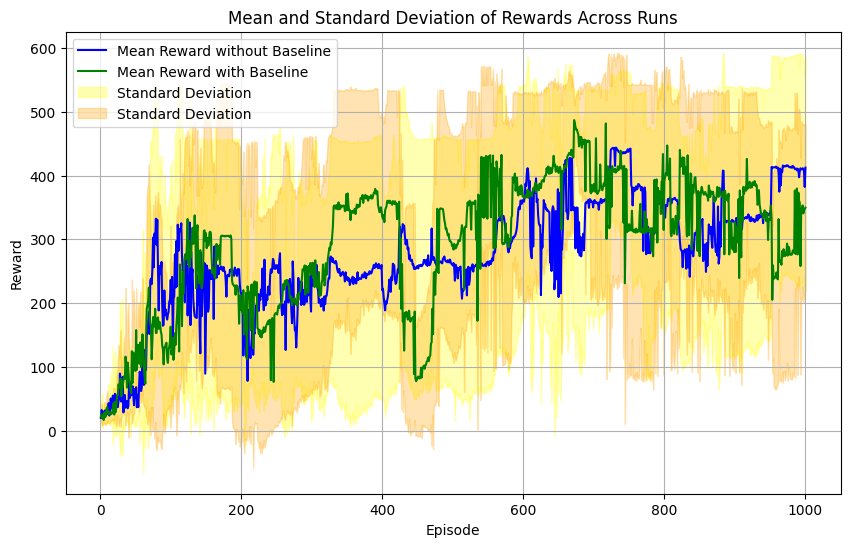

In [19]:
plot_scores(scores_5runs_basic, scores_5runs_baseline)

Run:  0


<ipython-input-10-238e93e9268b>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-10-238e93e9268b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = G = torch.tensor(G).to(DEVICE)


  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Run:  4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

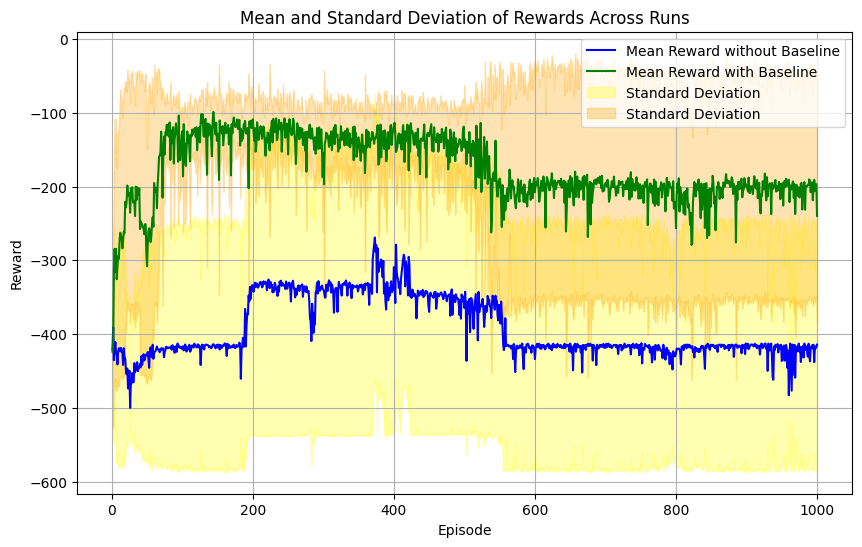

In [22]:
scores_5runs_baseline = []
scores_5runs_basic = []
for i in range(5):
  print("Run: ", i)
  scores = MC_REINFORCE('Acrobot-v1', 'n')
  scores_5runs_basic.append(scores)
  scores1 = MC_REINFORCE('Acrobot-v1', 'y')
  scores_5runs_baseline.append(scores1)
plot_scores(scores_5runs_basic, scores_5runs_baseline)